# A tour through Semisupervised learning

This notebook is intended to be a short, but thorough, introduction to semisupervised learning. We'll cover some basic stuff, including: the different methods, the first attempt to use semisupervised in Apache Spark and, hopefully, a first working version of Label Propagation.

In [1]:
%run initilization.py

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


/home/svanhmic/workspace/DABAI/Workflows


In [2]:
path = '/home/svanhmic/workspace/DABAI/Workflows/dist_workflow/'
packages = [path+'semisupervised.zip', path+'shared.zip', path+'cleaning.zip',
            path+'examples.zip', path+'classification.zip']
for p in packages:
    sc.addPyFile(p)

### Spring (2x helix) data

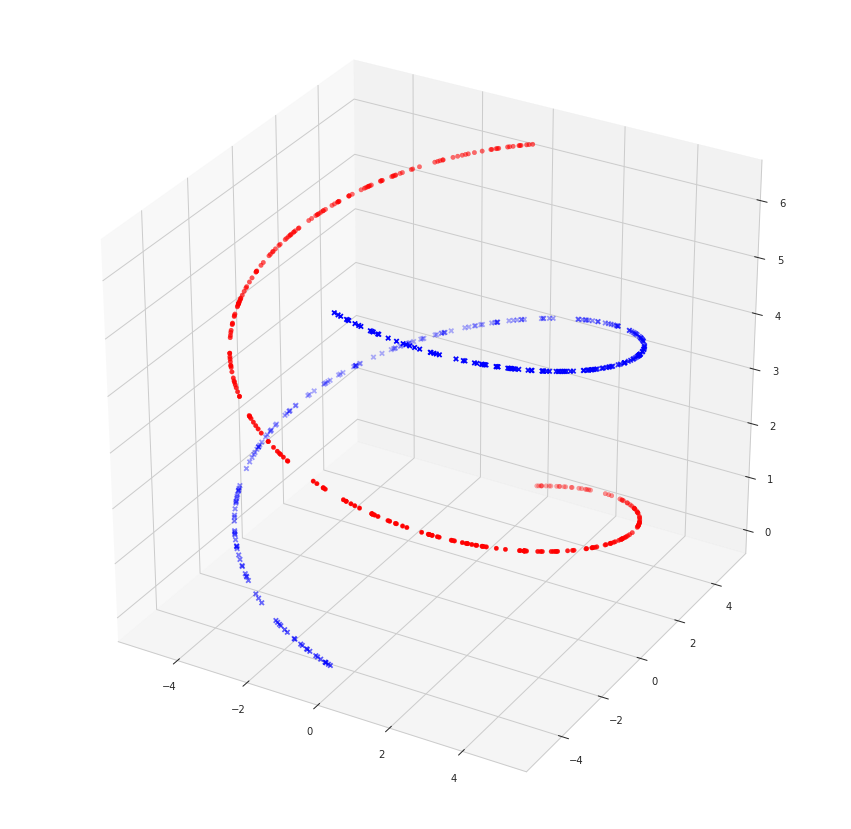

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
n = 300
x = np.random.uniform(0,2*3.14, n) # np.linspace(0,2*3.14,n)
a = 5.
b = 1
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
double_helix = []
for color, shape, par, number in [('r', 'o', a, 0), ('b','x', -a, 1)]:
    helix = np.array(list(map(lambda x: (par*np.sin(x),par*np.cos(x),b*x, number),x)))
    ax.scatter(xs=helix[:,0], ys= helix[:,1], zs=helix[:,2], c=color, marker=shape)
    double_helix.append(helix)
plt.show()

In [4]:
import functools 
missing_label_func = lambda x: np.random.permutation([x]+(n-1)*[np.NaN])
missing_label = np.reshape(np.hstack((missing_label_func(0.),missing_label_func(1.))),(2*n,1))

spring = np.hstack((np.vstack(double_helix),missing_label))
spring_pdf = pd.DataFrame(spring,columns='x y z org_label unknown_label'.split())
spring_pdf = spring_pdf.reset_index()
spring_pdf['id'] = spring_pdf['index']
del spring_pdf['index']
spring_pdf.head()
spring_df = spark.createDataFrame(spring_pdf)

In [5]:
from semisupervised.LabelPropagation import label_propagation
from shared.Extension_to_timeit import pretty_time_result
from pyspark.sql import functions as F

In [ ]:

lp_algorithm = functools.partial(
    label_propagation, sc=sc, label_col='unknown_label', eval_type='max',
    id_col='id',feature_cols=['x','y','z'], k=2, sigma=.4, max_iters=20)
all_transitions_df = []

model_timer = %timeit -r1 -o all_transitions_df.append(lp_algorithm(data_frame=spring_df))

print(pretty_time_result(model_timer))


In [ ]:
transition_df = all_transitions_df[0]
transition_df['row','label','initial_label'].show(600,truncate=False)

In [ ]:
merged_df = spring_df.alias('a').join(transition_df.alias('b'),F.col('row')==F.col('id'))

In [ ]:
merged_df.groupBy(F.col('label'),F.col('org_label')).count().show()

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
result_spring = merged_df.toPandas()
for i, color in zip(range(2),('r','b')):
    ax.scatter(xs=result_spring[result_spring.label == i]['x'],
               ys= result_spring[result_spring.label == i]['y'],
               zs=result_spring[result_spring.label == i]['z'],
               c=color,
               marker=shape)
    double_helix.append(helix)
plt.show()

### Performance testing Label Propgation
Identifying potential bottelnecks
#### First: Graph Generation
#### Second: Broadcasting summed data

In [6]:
spring_df.show()

+--------------------+-------------------+--------------------+---------+-------------+---+
|                   x|                  y|                   z|org_label|unknown_label| id|
+--------------------+-------------------+--------------------+---------+-------------+---+
|  -4.607156739531707|-1.9427060450278033|   4.313341096403711|      0.0|          NaN|  0|
|-0.48204289588125643|  4.976709218603234|   6.186626753114018|      0.0|          NaN|  1|
| 0.07476768752442378|  4.999440948036315|0.014954094850112041|      0.0|          NaN|  2|
|  -4.829930340796019| 1.2929705731601346|   4.973955510287862|      0.0|          NaN|  3|
|   4.998580805284771|0.11912150535753746|  1.5469697713792938|      0.0|          NaN|  4|
|   4.026347319982085| 2.9645450340436863|   0.936129805875204|      0.0|          NaN|  5|
|   4.989517985643121|-0.3235896644576487|  1.6355595225978679|      0.0|          NaN|  6|
|  2.3404889921392877| -4.418383333038774|   2.654455704983674|      0.0|       

In [25]:
from semisupervised.LP_Graph import create_complete_graph
from pyspark.sql import types as T
from pyspark.ml import feature as ml_feature
from pyspark.ml import Pipeline
from pyspark.mllib import linalg as mllib_linalg
from pyspark.ml import linalg as ml_linalg
from shared import ConvertAllToVecToMl
from py4j import protocol
from pyspark.mllib.linalg import distributed

In [12]:

matrix = create_complete_graph(sc, data_frame=spring_df, id_column='id', feature_columns=['x','y','z'], label_column='unknown_label', sigma=0.4)


In [27]:
irmatrix = matrix.toBlockMatrix()

In [34]:
mat = mllib_linalg.Matrices.dense(1,spring_df.count(),np.ones(spring_df.count()))
blocks1 = sc.parallelize([((0, 0), mat)])
blk_mat = distributed.BlockMatrix(blocks1,1024,1024)


In [38]:
summed = blk_mat.multiply(irmatrix)

In [39]:
summed.toLocalMatrix

DenseMatrix(1, 600, [25.5275, 15.71, 14.196, 28.8413, 21.5324, 20.5943, 21.5587, 24.6538, ..., 20.6716, 20.5622, 20.8177, 31.4146, 30.9403, 20.8309, 19.8989, 19.3126], 0)

In [41]:
rrmat= matrix.toIndexedRowMatrix()
rrmat.rows.map(lambda x: )

In [ ]:
def _compute_weights(vec_x, vec_y, sigma):
    #if isinstance(vec_y, ml_linalg.SparseVector) | isinstance(vec_x, ml_linalg.SparseVector):
    return np.exp(-vec_x.squared_distance(vec_y)/sigma**2)
def gen_graph(sc, data_frame, cols = None ):
    list_of_vars = [T.StructField('a_id', T.LongType()),
                    T.StructField('a_lab', T.DoubleType()),
                    T.StructField('b_id', T.LongType()),
                    T.StructField('b_lab', T.DoubleType()),
                    T.StructField('weights', T.DoubleType())
                   ]
    schema = T.StructType(list_of_vars)
    vectors = ml_feature.VectorAssembler(inputCols=cols,outputCol='features')
    converter = ConvertAllToVecToMl.ConvertAllToVecToMl(inputCol='features',outputCol='converteds')
    scaler = ml_feature.StandardScaler(withMean=True, withStd=True, inputCol='converteds', outputCol='std_features')
    pipeline = Pipeline(stages=[vectors, converter, scaler])
    model = pipeline.fit(data_frame)
    
    standard_X = model.transform(data_frame)

    to_sparse_udf = F.udf(lambda x: ml_linalg.SparseVector(len(x), [(i,j) for i,j in enumerate(x) if j != 0]), ml_linalg.VectorUDT())
    standard_X_sparse = standard_X.withColumn('weights', to_sparse_udf(F.col('std_features')))
    bc_vec = sc.broadcast(standard_X_sparse.select('id','weights').rdd.collectAsMap())
    
    #print(broadcasted_vectors.value.get(3))
    cartesian_rows = pyspark.Row('a_id','a_lab','b_id','b_lab','weights')
    rdd_srink = standard_X_sparse.rdd.map(lambda x: (x['id'], x['unknown_label']))
    rdd_cartesian = (rdd_srink
                     .cartesian(rdd_srink)
                     .map(lambda x: (*x[0],*x[1]))
                     .map(lambda x: distributed.MatrixEntry(
                         x[0],x[2], _compute_weights(bc_vec.value.get(x[0]),
                                                     bc_vec.value.get(x[2]),
                                                     0.42) 
                     ))
                    )
    return distributed.CoordinateMatrix(rdd_cartesian)

In [ ]:
output_df = gen_graph(sc, spring_df, 'x y z'.split())
try:
    print(output_df.entries.take(5))
except protocol.Py4JJavaError as e:
    print(e)

In [ ]:
output_df = gen_graph(sc, spring_df, 'x y z'.split())
%timeit -r1 -o output_df.collect()
print(output_df.rdd.getNumPartitions())

### Mnist dataset

In [ ]:
mnist_train_data = pd.DataFrame.from_csv(
    '/home/svanhmic/workspace/data/DABAI/mnist/train.csv',
    header=0,index_col=None)

In [ ]:
mnist_train_data['label'].count()

In [ ]:
from PIL import Image
import math
from matplotlib import pyplot as plt
from pyspark.sql import functions as F
from pyspark.ml.linalg import DenseVector, VectorUDT

pic_1 = mnist_train_data.iloc[2,1:].values.reshape((28,28))
plt.imshow(pic_1, interpolation='nearest',cmap='gray')
plt.show()

### Spark download

In [ ]:
to_vec = F.udf(lambda vec: DenseVector(np.array(vec)), VectorUDT())

mnist_train_df = spark.read.csv(
    '/home/svanhmic/workspace/data/DABAI/mnist/train.csv',
    inferSchema=True, header=True)
mnist_train_df = mnist_train_df.withColumn('id',F.monotonically_increasing_id())
# mnist_train_df = mnist_train_df.select('label',to_vec(F.array(mnist_train_df.columns[1:])).alias('pixels'))
mnist_train_df.printSchema()

In [ ]:
mnist_1_0_train_df = mnist_train_df.filter(F.col('label').isin(0,1))
mnist_1_0_train_df.count()

In [ ]:
sampled_no_nans = (mnist_1_0_train_df
                   .sampleBy('label', fractions={0: 0.03, 1: 0.03})
                   .withColumn('unknown_label', F.col('label'))
                   .select('id','unknown_label'))

#Show that it actually has sampled the right elements
sampled_no_nans['id','unknown_label'].show()
sampled_nans = (mnist_1_0_train_df.select('id').cache()
                .subtract(sampled_no_nans.select('id'))
                .withColumn('unknown_label',F.lit(np.NaN))
               )
sampled_nans.show()

### Merging the two data sets

### Lets run the algorithm:

In [ ]:
bd_nans =  sc.broadcast(sampled_nans.unionAll(sampled_no_nans).rdd.collectAsMap())
add_nan_udf = F.udf(lambda x: bd_nans.value.get(x),T.FloatType())
merged = mnist_train_df.withColumn('unknown_label',add_nan_udf(F.col('id')))
#merged_mnist_1_0_train_df.describe().show()

In [ ]:
output = gen_graph(sc, merged, cols=['pixel'+str(i) for i in range(784)])
output.entries.take(5)

In [ ]:
matrix = output.rdd.map(lambda x: distributed.MatrixEntry(x['a_id'],x['b_id'],x['weights']))

In [ ]:
matrix.take(5)

In [ ]:
from sklearn.semi_supervised import LabelPropagation

In [ ]:
input_df.show()

In [ ]:
pdf_mnist = input_df.toPandas()
data = pdf_mnist.loc[:,['pixel'+str(i) for i in range(784)]]
labels = pdf_mnist.loc[:,'unknown_label'].fillna(-1)
data.describe()

In [ ]:
lpa = LabelPropagation(gamma=5.4003)
result = lpa.fit(data.as_matrix(),labels)

In [ ]:
prediction = result.predict(data.as_matrix())

In [ ]:
pdf_mnist['prediction'] = prediction

In [ ]:
pdf_mnist.groupby(['label','prediction'],as_index=False)['id'].count()

In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
vectorizer = ml_feature.VectorAssembler(inputCols=['pixel'+str(i) for i in range(784)],outputCol='features')
conv = ConvertAllToVecToMl.ConvertAllToVecToMl(inputCol='features',outputCol='conved')
scaler = ml_feature.StandardScaler(withMean=True,withStd=True,inputCol='conved', outputCol='scaled')
km = KMeans(featuresCol='scaled')
pipeline = Pipeline(stages=[vectorizer,conv,scaler,km])

In [ ]:
model = pipeline.fit(input_df)

In [ ]:
model.transform(input_df)['prediction','id'].show()